### Importing some basic libraries required to play with the images

In [1]:
import os
import cv2
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [60]:
BASE_DIR = "/datasets/public1/upload/datasets/face_liveness/datasets/rgb_image/2.7_128x128/0"
TEST_DIR = "/datasets/public1/upload/datasets/face_liveness/datasets/rgb_image/2.7_128x128"

IMG_EXTENSIONS = [
    '.jpg', '.JPG', '.jpeg', '.JPEG',
    '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP',
]

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)

def make_dataset(dir):
    images = []
    assert os.path.isdir(dir), '%s is not a valid directory' % dir

    for root, _, fnames in sorted(os.walk(dir)):
        for fname in fnames:
            if is_image_file(fname):
                path = os.path.join(root, fname)
                images.append(path)

    return images


train_paths = make_dataset(BASE_DIR)
random.shuffle(train_paths)
len(train_paths)

train_paths = train_paths[:1000]
len(train_paths)

test_paths = make_dataset(TEST_DIR)
random.shuffle(test_paths)

### Display some of the face images given for training

Input samples:


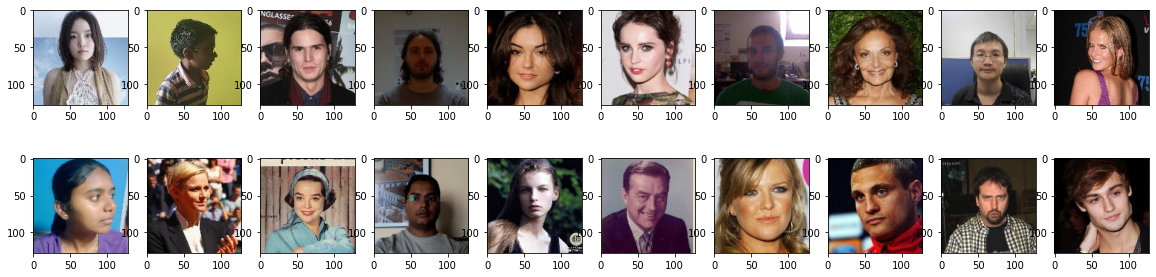

In [3]:
plt.figure(figsize=(20, 5))
print("Input samples:")
for i,pth in enumerate(train_paths[0:20]):
    im = cv2.imread(pth)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 10, i+1)
    plt.imshow(im, cmap='gray')
plt.show()

In [4]:
import random
import numpy as np 
import matplotlib.pyplot as plt 
import os, time, pickle, json 
from glob import glob 
from PIL import Image
import cv2 
from typing import List, Tuple, Dict
from statistics import mean 
from tqdm import tqdm 

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms 
from torchvision.utils import save_image
from torch.utils.data import DataLoader 

In [5]:
MEAN = (0.5, 0.5, 0.5,)
STD = (0.5, 0.5, 0.5,)


class Transform():
    def __init__(self, mean=MEAN, std=STD):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        
    def __call__(self, img: Image.Image):
        return self.data_transform(img)


class Dataset(object):
    def __init__(self, files: List[str], is_valid=False):
        self.files = files 
        self.trasformer = Transform()
        self.is_valid = is_valid
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        src = cv2.imread(self.files[idx])
        src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
        input_tensor = self.trasformer(Image.fromarray(src))

        return input_tensor, input_tensor 
    
    def __len__(self):
        return len(self.files)


def show_img_sample(img: torch.Tensor, img1: torch.Tensor):
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    ax = axes.ravel()
    ax[0].imshow(img.permute(1, 2, 0))
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title("input image", c="g")
    ax[1].imshow(img1.permute(1, 2, 0))
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_title("label image", c="g")
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

In [6]:
train_ds = Dataset(train_paths)
val_ds = Dataset(train_paths, True)
test_ds = Dataset(test_paths, True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


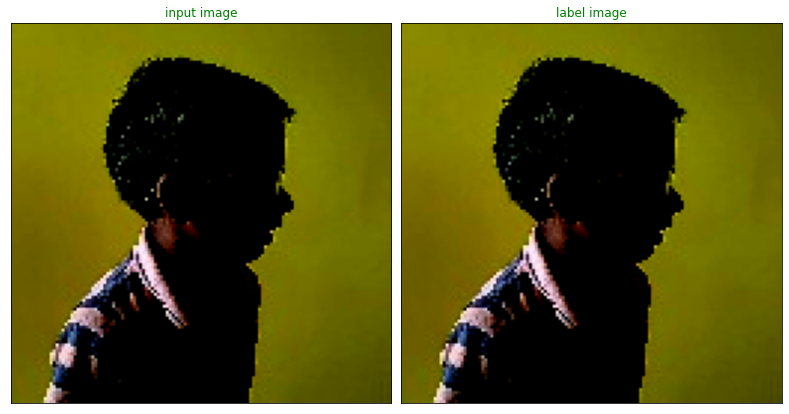

In [7]:
show_img_sample(val_ds.__getitem__(1)[0], val_ds.__getitem__(1)[1])

In [8]:
BATCH_SIZE = 1
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch.manual_seed(0)
np.random.seed(0)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [9]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

class Generator(nn.Module):
    # initializers
    def __init__(self, d=64):
        super().__init__()
        # Unet encoder
        self.conv1 = nn.Conv2d(3, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d * 2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d * 2)
        self.conv3 = nn.Conv2d(d * 2, d * 4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d * 4)
        self.conv4 = nn.Conv2d(d * 4, d * 8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d * 8)
        self.conv5 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
        self.conv5_bn = nn.BatchNorm2d(d * 8)
        self.conv6 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
        self.conv6_bn = nn.BatchNorm2d(d * 8)
        self.conv7 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
        self.conv7_bn = nn.BatchNorm2d(d * 8)
        self.conv8 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
        # self.conv8_bn = nn.BatchNorm2d(d * 8)

        # Unet decoder
        self.deconv1 = nn.ConvTranspose2d(d * 8, d * 8, 4, 2, 1)
        self.deconv1_bn = nn.BatchNorm2d(d * 8)
        self.deconv2 = nn.ConvTranspose2d(d * 8 * 2, d * 8, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d * 8)
        self.deconv3 = nn.ConvTranspose2d(d * 8 * 2, d * 8, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d * 8)
        self.deconv4 = nn.ConvTranspose2d(d * 8 * 2, d * 8, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d * 8)
        self.deconv5 = nn.ConvTranspose2d(d * 8 * 2, d * 4, 4, 2, 1)
        self.deconv5_bn = nn.BatchNorm2d(d * 4)
        self.deconv6 = nn.ConvTranspose2d(d * 4 * 2, d * 2, 4, 2, 1)
        self.deconv6_bn = nn.BatchNorm2d(d * 2)
        self.deconv7 = nn.ConvTranspose2d(d * 2 * 2, d, 4, 2, 1)
        self.deconv7_bn = nn.BatchNorm2d(d)
        self.deconv8 = nn.ConvTranspose2d(d * 2, 3, 4, 2, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        e1 = self.conv1(input)
        e2 = self.conv2_bn(self.conv2(F.leaky_relu(e1, 0.2)))
        e3 = self.conv3_bn(self.conv3(F.leaky_relu(e2, 0.2)))
        e4 = self.conv4_bn(self.conv4(F.leaky_relu(e3, 0.2)))
        e5 = self.conv5_bn(self.conv5(F.leaky_relu(e4, 0.2)))
        e6 = self.conv6_bn(self.conv6(F.leaky_relu(e5, 0.2)))
        # e7 = self.conv7_bn(self.conv7(F.leaky_relu(e6, 0.2)))
        e8 = self.conv8(F.leaky_relu(e6, 0.2))
        # e8 = self.conv8_bn(self.conv8(F.leaky_relu(e7, 0.2)))
        d1 = F.dropout(self.deconv1_bn(self.deconv1(F.relu(e8))), 0.5, training=True)
        # d1 = torch.cat([d1, e7], 1)
        # d2 = F.dropout(self.deconv2_bn(self.deconv2(F.relu(d1))), 0.5, training=True)
        d2 = torch.cat([d1, e6], 1)
        d3 = F.dropout(self.deconv3_bn(self.deconv3(F.relu(d2))), 0.5, training=True)
        d3 = torch.cat([d3, e5], 1)
        d4 = self.deconv4_bn(self.deconv4(F.relu(d3)))
        # d4 = F.dropout(self.deconv4_bn(self.deconv4(F.relu(d3))), 0.5)
        d4 = torch.cat([d4, e4], 1)
        d5 = self.deconv5_bn(self.deconv5(F.relu(d4)))
        d5 = torch.cat([d5, e3], 1)
        d6 = self.deconv6_bn(self.deconv6(F.relu(d5)))
        d6 = torch.cat([d6, e2], 1)
        d7 = self.deconv7_bn(self.deconv7(F.relu(d6)))
        d7 = torch.cat([d7, e1], 1)
        d8 = self.deconv8(F.relu(d7))
        o = F.tanh(d8)

        return o

In [10]:
class Discriminator(nn.Module):
    # initializers
    def __init__(self, d=64):
        super().__init__()
        self.conv1 = nn.Conv2d(6, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d * 2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d * 2)
        self.conv3 = nn.Conv2d(d * 2, d * 4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d * 4)
        self.conv4 = nn.Conv2d(d * 4, d * 8, 4, 1, 1)
        self.conv4_bn = nn.BatchNorm2d(d * 8)
        self.conv5 = nn.Conv2d(d * 8, 1, 4, 1, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input, label):
        x = torch.cat([input, label], 1)
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = F.sigmoid(self.conv5(x))

        return x

In [11]:
def train_fn(train_dl, G, D, criterion_bce, criterion_mae, optimizer_g, optimizer_d):
    G.train()
    D.train()
    LAMBDA = 100.0
    total_loss_g, total_loss_d = [], []
    for i, (input_img, real_img) in enumerate(tqdm(train_dl)):
        input_img = input_img.to(device)
        real_img = real_img.to(device)
        
        real_label = torch.ones(input_img.size()[0], 1, 14, 14).to(device)
        fake_label = torch.zeros(input_img.size()[0], 1, 14, 14).to(device)
        # Generator 
        fake_img = G(input_img)
        fake_img_ = fake_img.detach() # commonly using 
        out_fake = D(fake_img, input_img)
        
        loss_g_bce = criterion_bce(out_fake, real_label) # binaryCrossEntropy
        loss_g_mae = criterion_mae(fake_img, real_img) # MSELoss

        loss_g = loss_g_bce + LAMBDA * loss_g_mae 
        total_loss_g.append(loss_g.item())
        
        optimizer_g.zero_grad()
        optimizer_d.zero_grad()
        loss_g.backward(retain_graph=True)
        optimizer_g.step()
        # Discriminator
        out_real = D(real_img, input_img)
        loss_d_real = criterion_bce(out_real, real_label)
        out_fake = D(fake_img_, input_img)
        loss_d_fake = criterion_bce(out_fake, fake_label)
        loss_d = loss_d_real + loss_d_fake 
        total_loss_d.append(loss_d.item())
        
        optimizer_g.zero_grad()
        optimizer_d.zero_grad()
        loss_d.backward()
        optimizer_d.step()
    return mean(total_loss_g), mean(total_loss_d), fake_img.detach().cpu() 

def de_norm(img):
    img_ = img.mul(torch.FloatTensor(STD).view(3, 1, 1))
    img_ = img_.add(torch.FloatTensor(MEAN).view(3, 1, 1)).detach().numpy()
    img_ = np.transpose(img_, (1, 2, 0))
    return img_

def saving_img(fake_img, e):
    os.makedirs("generated", exist_ok=True)
    for i in range(BATCH_SIZE):
        output_img = (255 * de_norm(fake_img[i])).astype(np.uint8)
        output_img = cv2.cvtColor(output_img, cv2.COLOR_RGB2BGR)
        cv2.imwrite(f'generated/fake{str(e)}.png', output_img)
    #     save_image(fake_img, f"generated/fake{str(e)}.png", range=(-1.0, 1.0), normalize=True)
    
def saving_logs(result):
    with open("train.pkl", "wb") as f:
        pickle.dump([result], f)
        
def saving_model(D, G, e):
    os.makedirs("weight", exist_ok=True)
    torch.save(G.state_dict(), f"weight/G{str(e+1)}.pth")
    torch.save(D.state_dict(), f"weight/D{str(e+1)}.pth")
        
def show_losses(g, d):
    fig, axes = plt.subplots(1, 2, figsize=(14,6))
    ax = axes.ravel()
    ax[0].plot(np.arange(len(g)).tolist(), g)
    ax[0].set_title("Generator Loss")
    ax[1].plot(np.arange(len(d)).tolist(), d)
    ax[1].set_title("Discriminator Loss")
    plt.show()


def train_loop(train_dl, G, D, num_epoch, lr=0.0002, betas=(0.5, 0.999)):
    G.to(device)
    D.to(device)
    optimizer_g = torch.optim.Adam(G.parameters(), lr=lr, betas=betas)
    optimizer_d = torch.optim.Adam(D.parameters(), lr=lr, betas=betas)
    criterion_mae = nn.L1Loss()
    criterion_bce = nn.BCEWithLogitsLoss()
    total_loss_d, total_loss_g = [], []
    result = {}
    
    for e in range(num_epoch):
        loss_g, loss_d, fake_img = train_fn(train_dl, G, D, criterion_bce, criterion_mae, optimizer_g, optimizer_d)
        total_loss_d.append(loss_d)
        total_loss_g.append(loss_g)
        saving_img(fake_img, e+1)
        
#         if e%10 == 0:
        saving_model(D, G, e)
    try:
        result["G"] = total_loss_d 
        result["D"] = total_loss_g 
        saving_logs(result)
        show_losses(total_loss_g, total_loss_d)
    finally:
        return G, D 
    
    saving_model(D, G, num_epoch)
    print("successfully save model")

  0%|                                                                                                                                                                                                          | 0/1000 [00:00<?, ?it/s]/home/ubuntu/miniconda3/envs/humanode/lib/python3.7/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/ubuntu/miniconda3/envs/humanode/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:44<00:00, 22.72it/s]


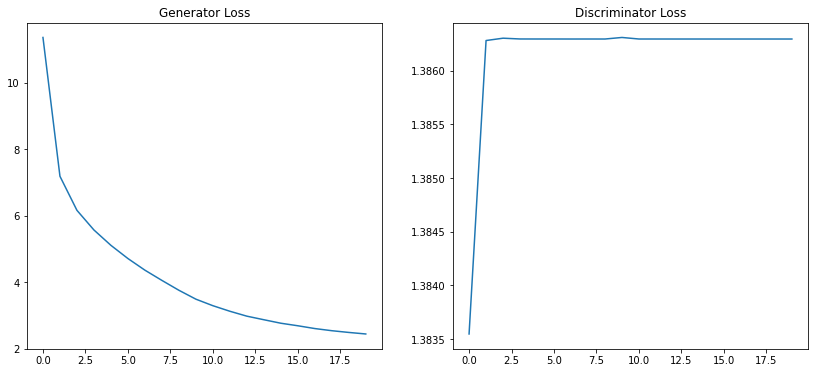

In [12]:
G = Generator()
D = Discriminator()
G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)

EPOCH = 20
trained_G, trained_D = train_loop(train_dl, G, D, EPOCH)

In [83]:
def load_model(name):
    G = Generator()
    G.load_state_dict(torch.load(f"weight/G{name}.pth", map_location={"cuda:0": "cpu"}))
    G.eval()
    return G.to(device)

def train_show_img(name, G):
#     G = load_model(name)
    root = "generated"
    fig, axes = plt.subplots(1, int(name), figsize=(36, 36))
    ax = axes.ravel()
    for i in range(int(name)):
        filename = os.path.join(root, f"fake{str(i+1)}.png")
        ax[i].imshow(Image.open(filename))
        ax[i].set_xticks([])
        ax[i].set_yticks([])

def evaluate(val_dl, name, G):
    criterion_mae = nn.L1Loss()
    with torch.no_grad():
        fig, axes = plt.subplots(1, 3, figsize=(40, 40))
        ax = axes.ravel()
#         G = load_model(name)
        threshold = 0.02
        count = 0
        total_loss = 0
        for input_img, real_img in tqdm(val_dl):
            input_img = input_img.to(device)
            real_img = real_img.to(device)
            
            fake_img = G(input_img)
            loss_g_mae = criterion_mae(fake_img, real_img) # MSELoss
            total_loss += loss_g_mae.cpu().detach().numpy()
            count += 1
            batch_size = input_img.size()[0]
            batch_size_2 = batch_size * 2 
            
            for i in range(batch_size):
                ax[i].imshow(de_norm(input_img[i].cpu()))
                ax[i+batch_size].imshow(de_norm(real_img[i].cpu()))
                ax[i+batch_size_2].imshow(de_norm(fake_img[i].cpu()))
                ax[i].set_xticks([])
                ax[i].set_yticks([])
                ax[i+batch_size].set_xticks([])
                ax[i+batch_size].set_yticks([])
                ax[i+batch_size_2].set_xticks([])
                ax[i+batch_size_2].set_yticks([])
                if i == 0:
                    ax[i].set_ylabel("Input Image", c="g", fontsize=20)
                    ax[i+batch_size].set_ylabel("Real Image", c="g", fontsize=20)
                    ax[i+batch_size_2].set_ylabel("Generated Image", c="r", fontsize=20)
            plt.subplots_adjust(wspace=0, hspace=0)
        
        print(f"Average loss: {total_loss/count:.02f}")
        
def test_imgs(test_paths):
    transform = Transform()
    
    criterion_mae = nn.L1Loss()
    total_loss = 0
    count = 0
    correct_count = 0
    for image_path in tqdm(test_paths):
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = transform(image)
        image = image.to(device)
        image = image.unsqueeze(0)
        
        fake_img = G(image)
        loss_g_mae = criterion_mae(fake_img, image) # MSELoss
        total_loss += loss_g_mae.cpu().detach().numpy()
        loss = loss_g_mae.cpu().detach().numpy()
        count += 1
        
        label = 0 if "2.7_128x128/0" in image_path else 1
        pred = 0 if loss < 0.01 else 1
        if label == pred:
            correct_count += 1    
        
    print(f"Accuracy: {100 * correct_count / count:.02f}")

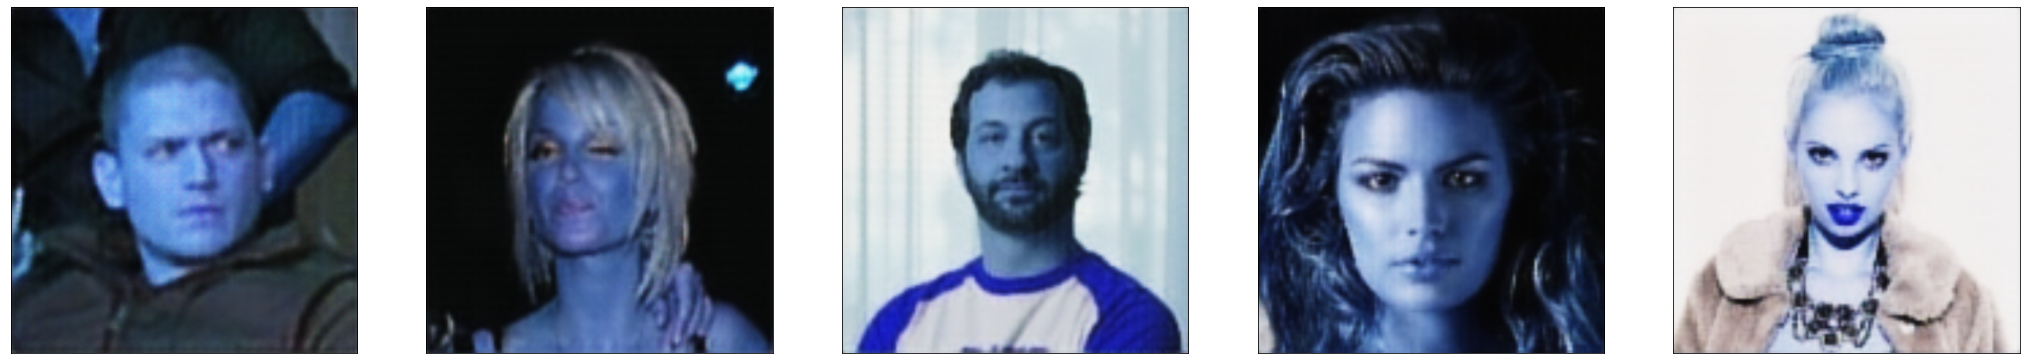

In [73]:
train_show_img(5, trained_G)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.43it/s]


Average loss: 0.02


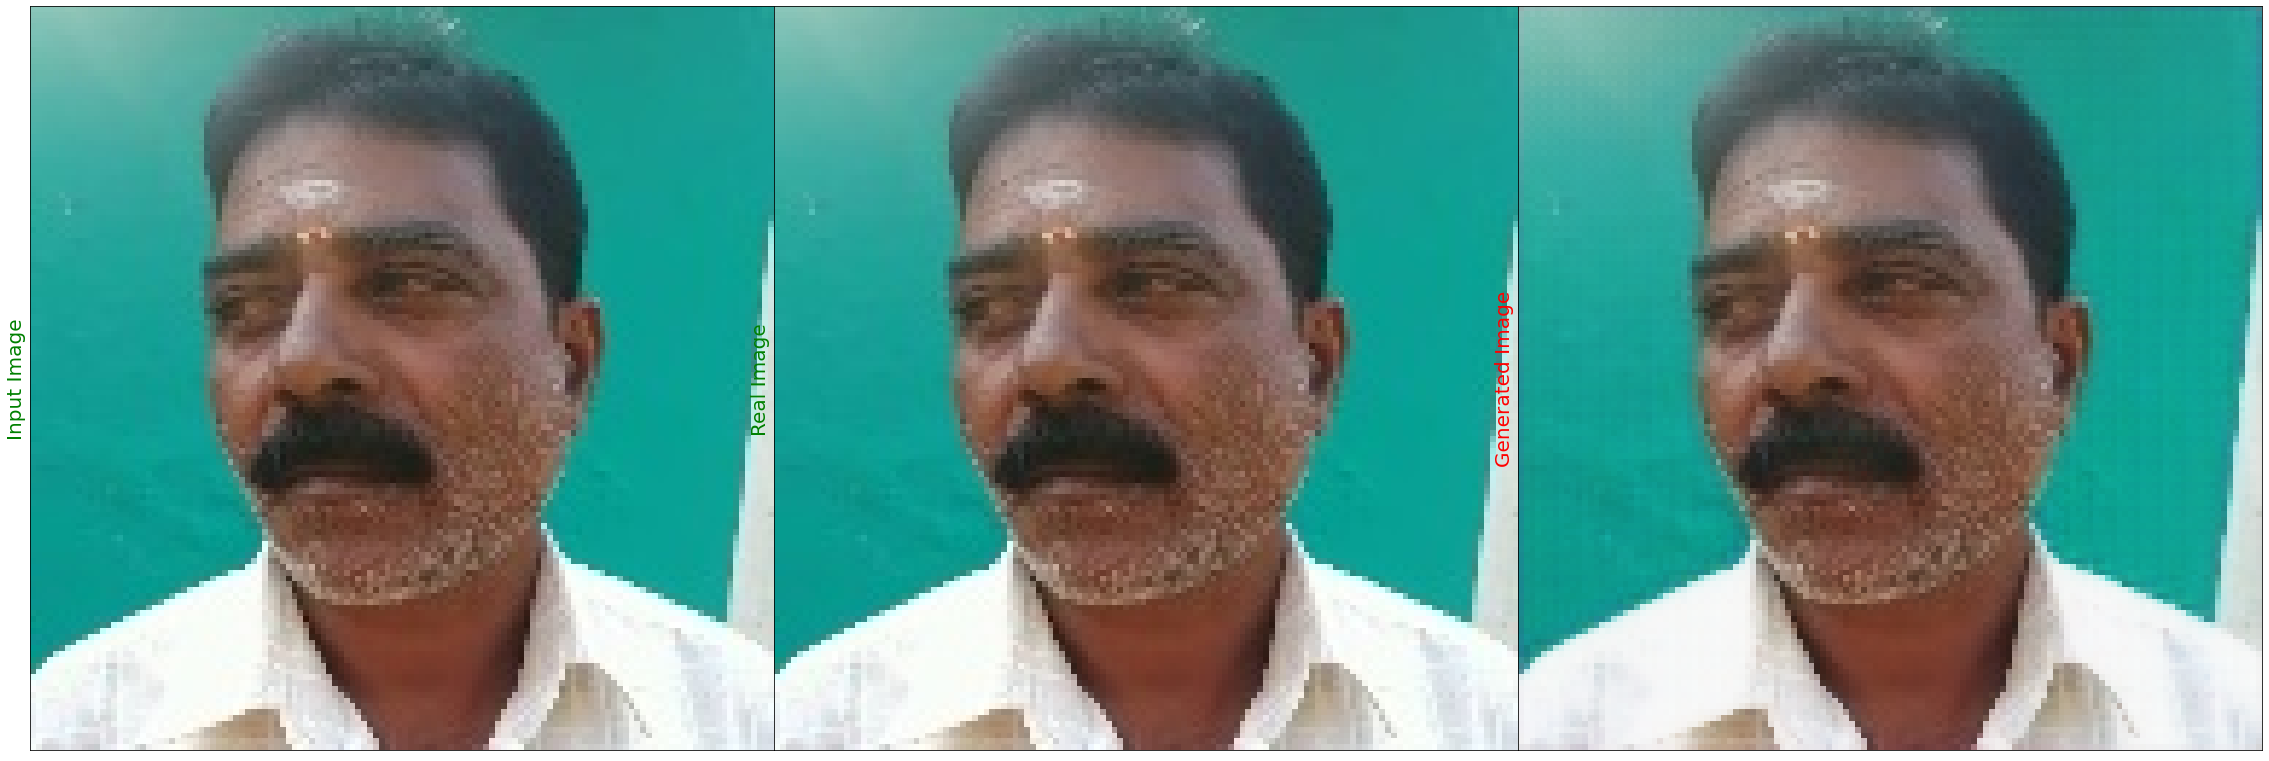

In [67]:
evaluate(val_dl, 5, trained_G)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 83.03it/s]


Average loss: 0.02


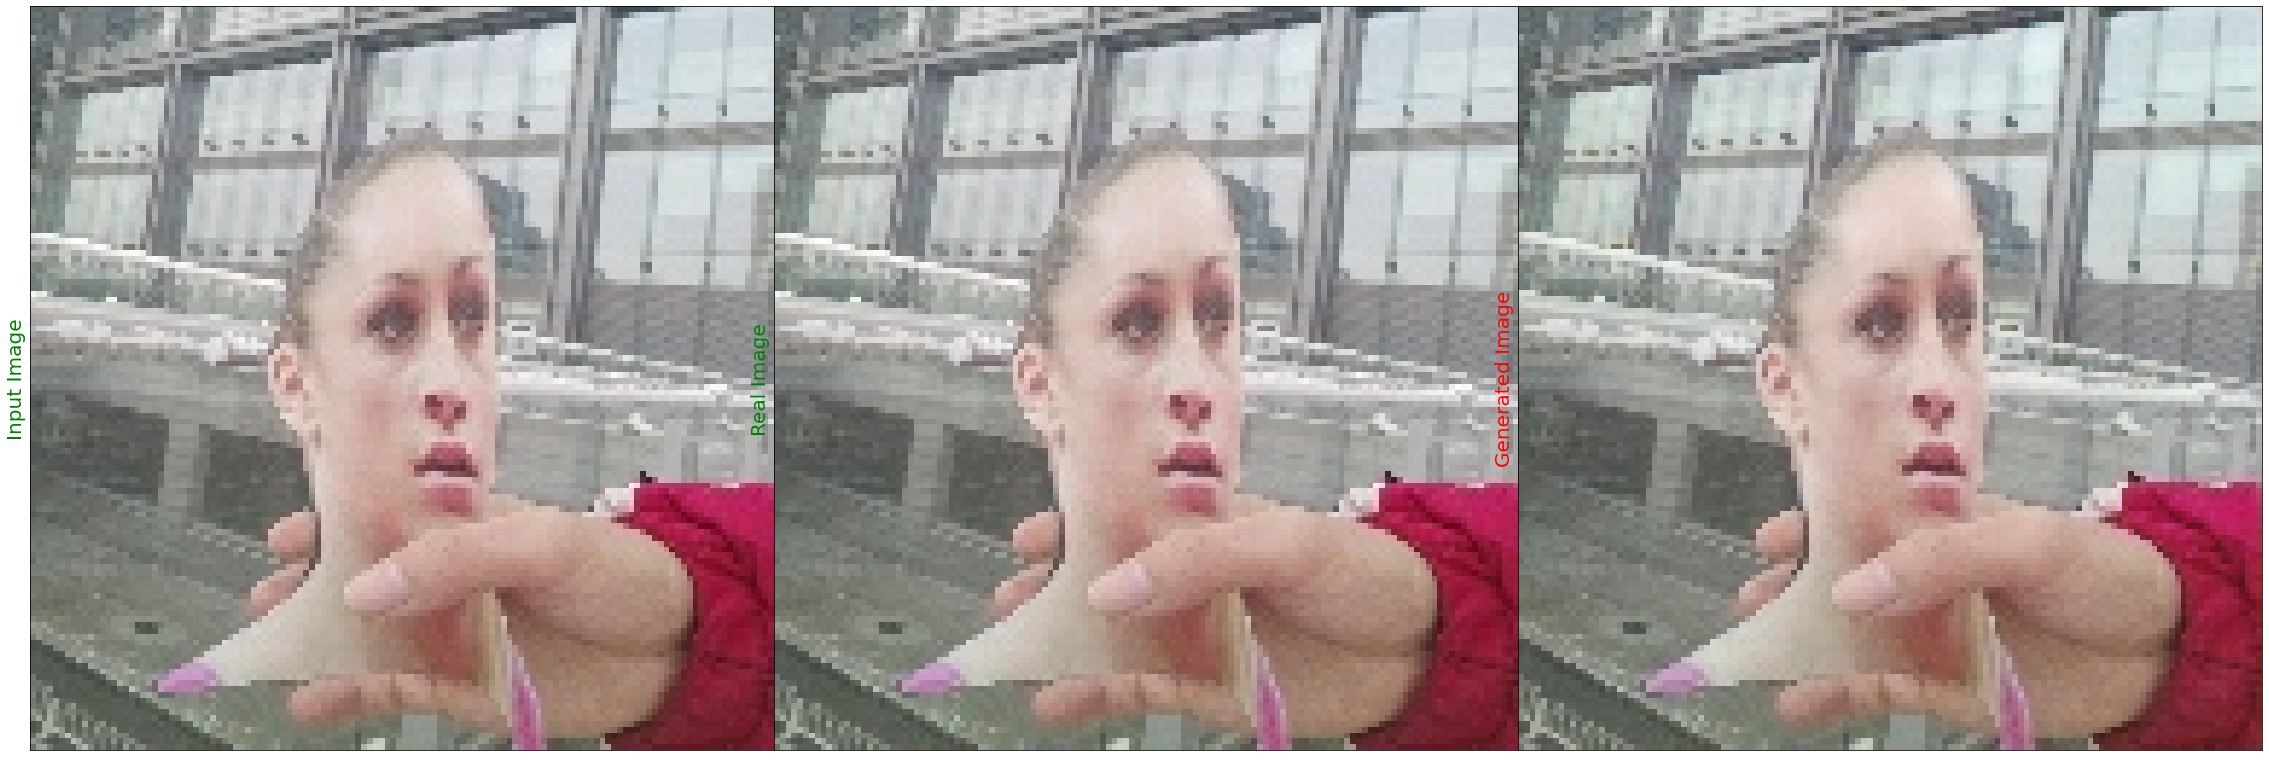

In [79]:
evaluate(test_dl, 5, trained_G)

In [88]:
test_imgs(test_paths)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 686051/686051 [1:36:43<00:00, 118.22it/s]

Accuracy: 62.01


## Result preparation:

In [55]:
TEST_DIR = BASE_DIR + "/test/test/"
OUTPUT_DIR = BASE_DIR + "/results"

try:
    os.mkdir(OUTPUT_DIR)
except Exception:
    pass
final_img_paths = sorted(glob(TEST_DIR+"*.png"))
len(final_img_paths)

0

### We have to predict/recreate 300 images from the given test set to make submissions

In [56]:
transformer = Transform()
for i,full_pth in enumerate(final_img_paths):
    name = i+1
    pth = full_pth.split('/')[-1]
    img = cv2.imread(TEST_DIR+pth.strip())
    with torch.no_grad():
        img = transformer(Image.fromarray(img))
        img = img.unsqueeze(0).to(device)
        res_img = G(img)
        output_img = (255 * de_norm(res_img[0].cpu())).astype(np.uint8)
        output_img = cv2.resize(output_img, (400, 400))
        
        smoothed = cv2.GaussianBlur(output_img, (9, 9), 10)
        unsharped = cv2.addWeighted(output_img, 1.5, smoothed, -0.5, 0)
        gray = cv2.cvtColor(unsharped, cv2.COLOR_BGR2GRAY)
        cv2.imwrite(f'{OUTPUT_DIR}/{i}.png', gray)

### Visualize the test set:

In [45]:
plt.figure(figsize=(20, 5))
for i,pth in enumerate(final_img_paths[0:20]):
    im = cv2.imread(pth, 0)
    plt.subplot(2, 10, i+1)
    plt.imshow(im, cmap='gray')
plt.show()

<Figure size 1440x360 with 0 Axes>

### Visualize some of the results:

In [46]:
results_img_paths = glob(f'{OUTPUT_DIR}/*.png')
plt.figure(figsize=(20, 5))

for i,pth in enumerate(results_img_paths[0:20]):
    im = cv2.imread(pth, 0)
    plt.subplot(2, 10, i+1)
    plt.imshow(im, cmap='gray')
plt.show()

<Figure size 1440x360 with 0 Axes>

> 